# Análisis exploratorio de datos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pob_df=pd.read_parquet('tidy_data/son_pobl.parquet')
ue_df=pd.read_parquet('tidy_data/son_ue.parquet')
del_df=pd.read_parquet('tidy_data/son_del.parquet')

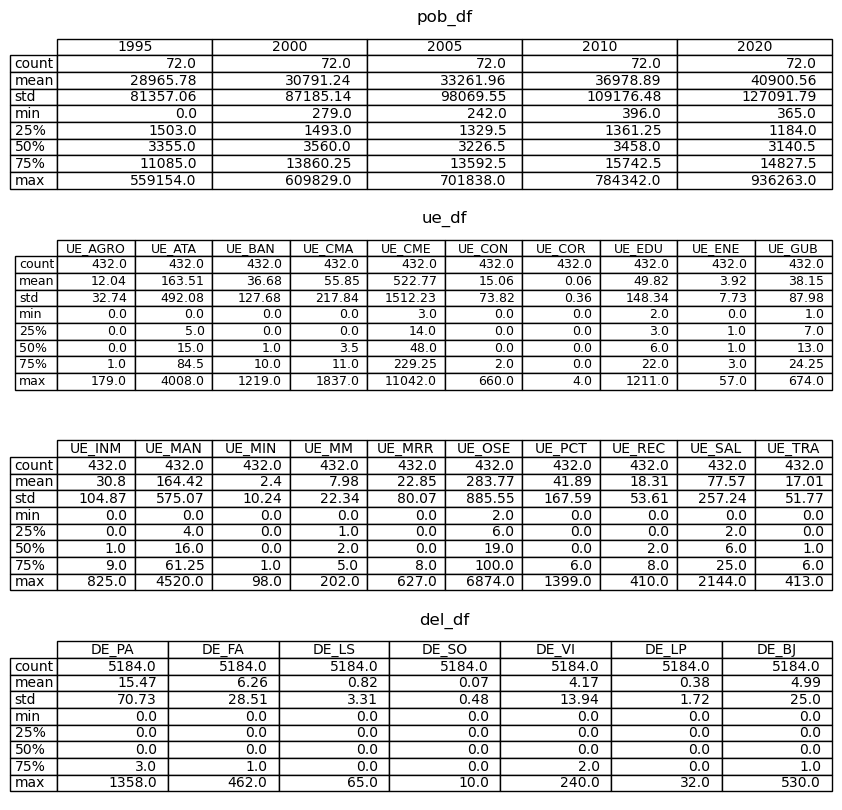

In [3]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))

ax[0].table(cellText=np.round(pob_df.describe().values, decimals=2),
    colLabels=pob_df.describe().columns,
    rowLabels=pob_df.describe().index,
    loc='center')
ax[0].set_title('pob_df')
ax[0].axis('off')
ax[0].axis('tight')

ax[1].table(cellText=np.round(ue_df.iloc[:,1:11].describe().values, decimals=2),
    colLabels=ue_df.iloc[:,1:12].describe().columns,
    rowLabels=ue_df.iloc[:,1:12].describe().index,
    loc='center')
ax[1].set_title('ue_df')
ax[1].axis('off')
ax[1].axis('tight')

ax[2].table(cellText=np.round(ue_df.iloc[:,11:21].describe().values, decimals=2),
    colLabels=ue_df.iloc[:,11:21].describe().columns,
    rowLabels=ue_df.iloc[:,11:21].describe().index,
    loc='center')
ax[2].axis('off')
ax[2].axis('tight')

ax[3].table(cellText=np.round(del_df.describe().values, decimals=2),
    colLabels=del_df.describe().columns,
    rowLabels=del_df.describe().index,
    loc='center')
ax[3].set_title('del_df')
ax[3].axis('off')
ax[3].axis('tight')

plt.show()

## Exploración del dataset de población

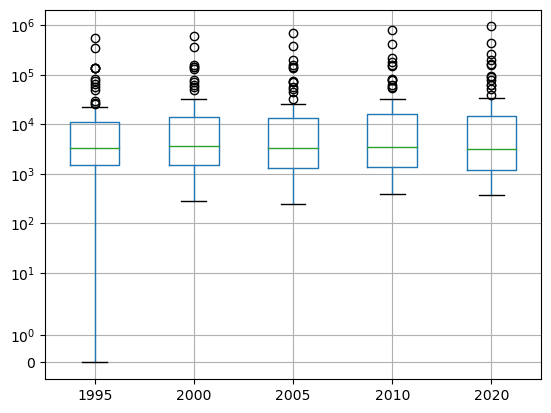

In [4]:
pob_boxplot=pob_df.boxplot()
pob_boxplot.set_yscale('symlog')

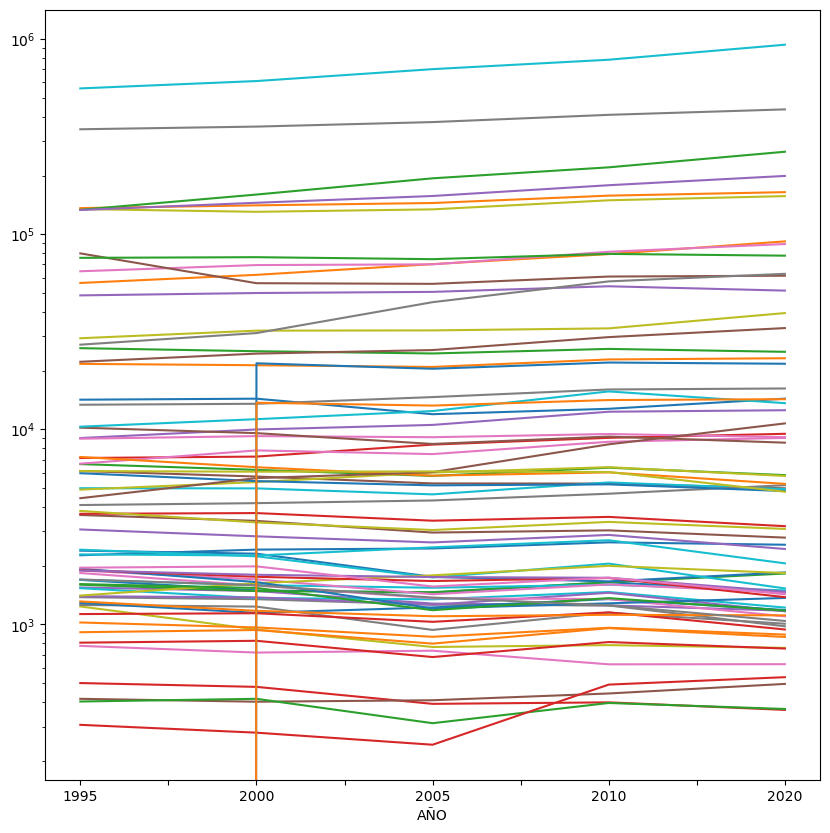

In [5]:
pob_df_tmp=pob_df.melt(id_vars=['ID'], var_name='AÑO', value_name='POB')
pob_df_tmp.set_index('AÑO', inplace=True)
pob_lines=pob_df_tmp.groupby('ID')['POB'].plot(figsize=(10,10), logy=True)

## Exploración del dataset de UE

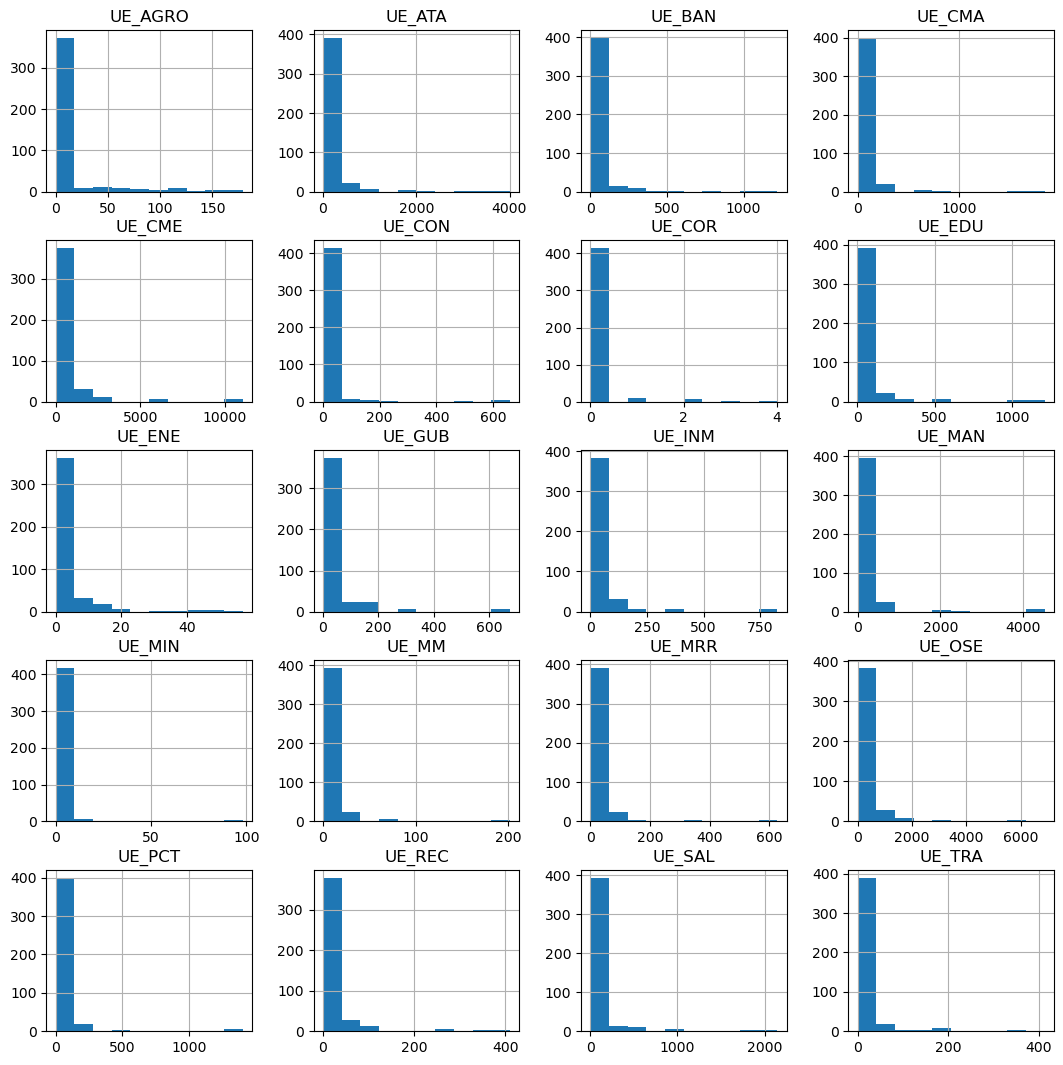

In [6]:
ue_hist=ue_df.select_dtypes('number').hist(figsize=(13, 13))

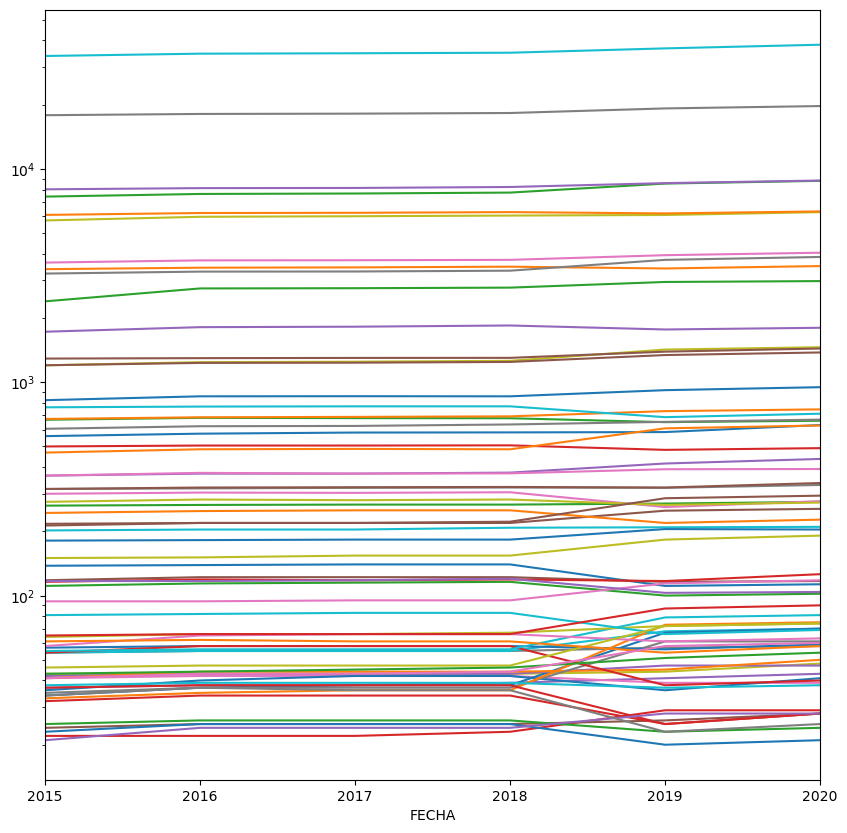

In [7]:
ue_df_tmp=ue_df.copy()
ue_df_tmp['UE_TOT']=ue_df_tmp.iloc[:,1:21].sum(axis=1)
ue_df_tmp=ue_df_tmp[['ID', 'FECHA', 'UE_TOT']]
ue_df_tmp.set_index('FECHA', inplace=True)
ue_lines=ue_df_tmp.groupby('ID')['UE_TOT'].plot(figsize=(10,10), logy=True)

## Exploración del dataset de incidencia delictiva

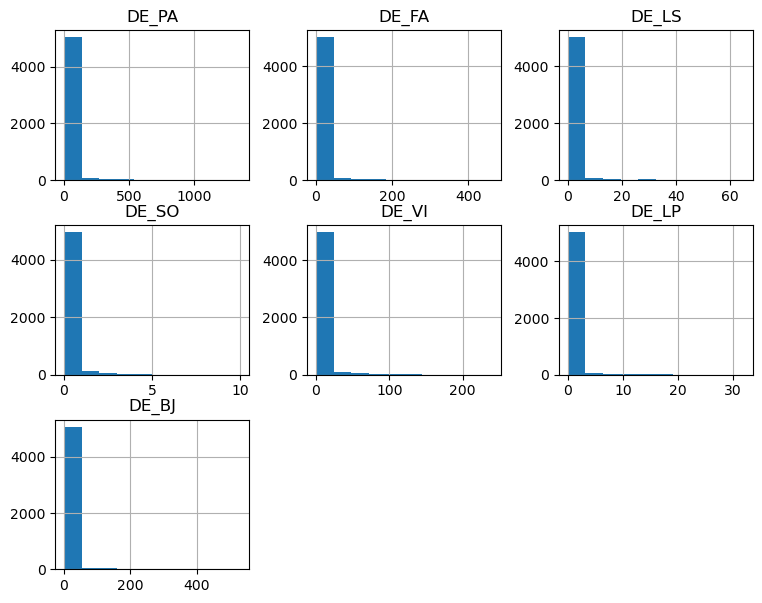

In [8]:
del_hist=del_df.select_dtypes('number').hist(figsize=(9, 7))

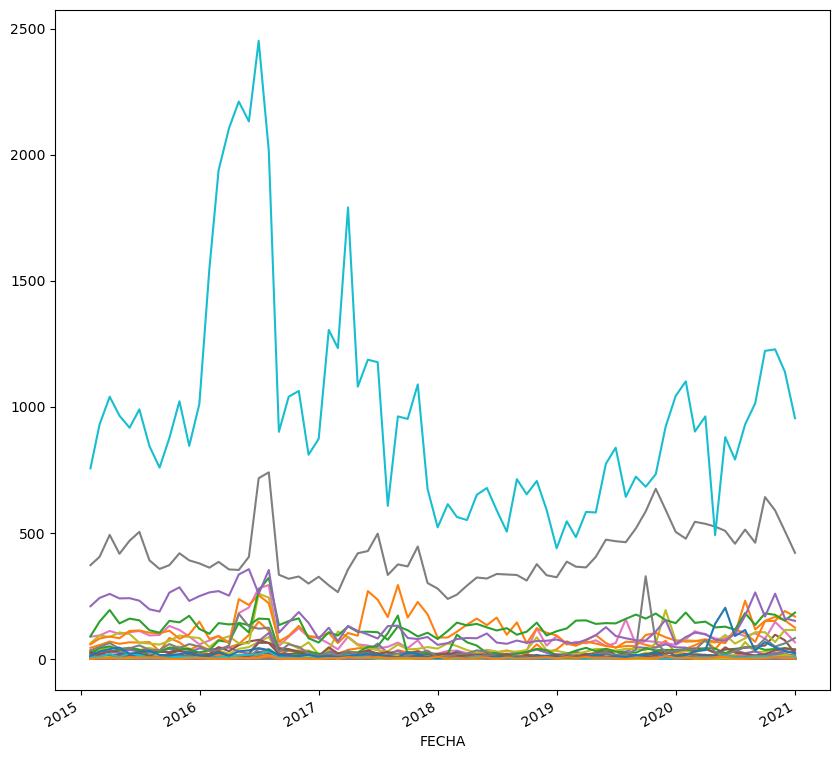

In [9]:
del_df_tmp=del_df.copy()
del_df_tmp['DEL_TOT']=del_df_tmp.iloc[:,2:].sum(axis=1)
del_df_tmp=del_df_tmp[['ID', 'FECHA', 'DEL_TOT']]
del_df_tmp.set_index('FECHA', inplace=True)
del_lines=del_df_tmp.groupby('ID')['DEL_TOT'].plot(figsize=(10,10))

## PCA

In [10]:
del_pca=del_df.copy()
del_pca['DEL_TOT']=del_pca.iloc[:,2:].sum(axis=1)
del_pca=del_pca[['ID', 'FECHA', 'DEL_TOT']]
del_pca=del_pca.groupby(['ID', del_pca['FECHA'].dt.year]).sum().reset_index()

ue_pca=ue_df.copy()
ue_pca['FECHA']=ue_pca['FECHA'].dt.year
pca_df=del_pca.merge(ue_pca, how='outer', on=['ID','FECHA'])

In [11]:
pca_df_st=pca_df.copy()
pca_df_st=pca_df_st.iloc[:, 2:]
for column in pca_df_st.columns:
    pca_df_st[column] = StandardScaler().fit_transform(pca_df_st[column].values.reshape(-1,1))

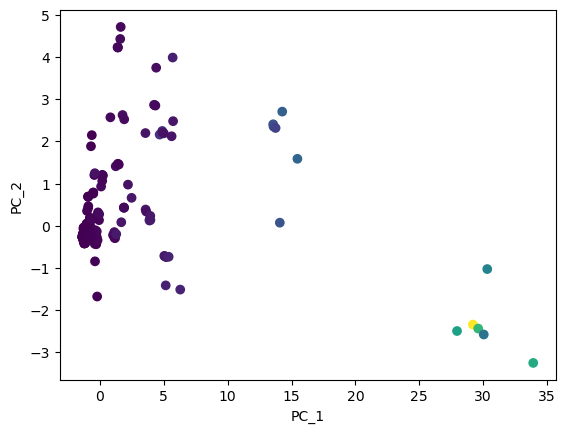

In [12]:
pca=PCA(n_components=5)
p_comps=pca.fit_transform(pca_df_st.iloc[:, 1:])
df_PCA = pd.DataFrame(data=p_comps)
pc_scatter=plt.scatter(x=df_PCA.iloc[:,0], y=df_PCA.iloc[:,1], c=pca_df_st['DEL_TOT'])
plt.ylabel('PC_2')
plt.xlabel('PC_1')
plt.show()

In [13]:
mvp_col=[np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
col_nom=pca_df_st.iloc[:, 1:].columns
mvp_nom=[col_nom[mvp_col[i]] for i in range(pca.components_.shape[0])]
pc_dict = {f'PC_{i}': mvp_nom[i] for i in range(pca.components_.shape[0])}
pd.DataFrame(pc_dict.items())

,0,1
0,PC_0,UE_EDU
1,PC_1,UE_AGRO
2,PC_2,UE_COR
3,PC_3,UE_AGRO
4,PC_4,UE_ENE


## Generación de características

In [14]:
g_pob_df=pob_df.copy()
g_pob_df[['2015', '2016', '2017', '2018', '2019']]=np.nan
g_pob_df=g_pob_df.melt(id_vars=['ID'], var_name='FECHA', value_name='POB')
g_pob_df.sort_values(by=['ID', 'FECHA'], inplace=True, ignore_index=True)
g_pob_df=g_pob_df.interpolate(method ='linear', limit_direction ='forward')
g_pob_df=g_pob_df[g_pob_df['FECHA'].isin(['2015', '2016', '2017', '2018', '2019', '2020'])]
g_pob_df['POB']=g_pob_df['POB'].round(2)


In [15]:
g_pob_df

,ID,FECHA,POB
4,26001,2015,2624.67
5,26001,2016,2612.33
6,26001,2017,2600.00
7,26001,2018,2587.67
8,26001,2019,2575.33
...,...,...,...
715,26072,2016,14183.67
716,26072,2017,14207.50
717,26072,2018,14231.33
718,26072,2019,14255.17


In [16]:
del_edu_df=del_df.groupby(['ID', del_df['FECHA'].dt.year]).sum().reset_index()
del_edu_df=del_edu_df.merge(ue_pca[['ID','FECHA','UE_EDU']], how='outer', on=['ID','FECHA'])
del_edu_df['FECHA']=del_edu_df['FECHA'].astype(str)
del_edu_df=del_edu_df.merge(g_pob_df, how='outer', on=['ID','FECHA'])
for col in del_edu_df.iloc[:, 2:-1].columns:
    del_edu_df[col]=(del_edu_df[col]/del_edu_df['POB'])*100000

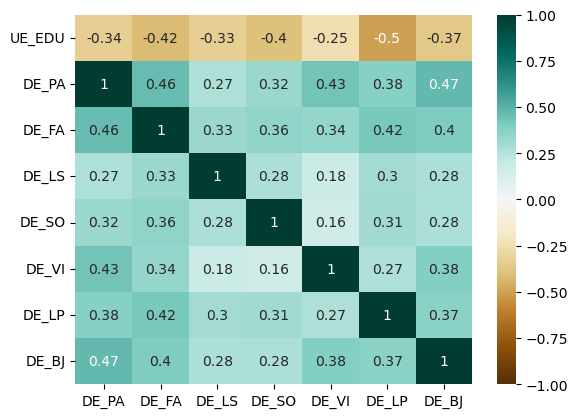

In [17]:
del_edu_df.round(2)
fig, ax=plt.subplots()#figsize=(10,15))
heatmap=sns.heatmap(del_edu_df[['UE_EDU','DE_PA','DE_FA',
    'DE_LS','DE_SO','DE_VI','DE_LP','DE_BJ']].round(2).corr(method ='spearman')\
    [['DE_PA','DE_FA','DE_LS','DE_SO','DE_VI','DE_LP','DE_BJ']],
    vmax=1, vmin=-1, annot=True, cmap='BrBG', ax=ax)
fig.show()

## Generación de datasets

In [18]:
g_del_df=del_df.copy()
g_del_df['AÑO']=g_del_df['FECHA'].dt.year

g_ue_df=ue_df.copy()
g_ue_df['AÑO']=g_ue_df['FECHA'].dt.year

son_df=g_del_df.merge(g_ue_df[['ID','AÑO','UE_EDU']], how='outer', on=['ID','AÑO'])


## Diccionario de datos

In [23]:
del_edu_df
#son_df

,ID,FECHA,DE_PA,DE_FA,DE_LS,DE_SO,DE_VI,DE_LP,DE_BJ,UE_EDU,POB
0,26001,2015,152.400111,0.000000,38.100028,0.0,76.200056,0.000000,76.200056,152.400111,2624.67
1,26001,2016,1186.680090,459.360035,0.000000,0.0,229.680017,76.560006,191.400015,153.120012,2612.33
2,26001,2017,346.153846,38.461538,0.000000,0.0,192.307692,38.461538,153.846154,153.846154,2600.00
3,26001,2018,347.803236,0.000000,0.000000,0.0,38.644804,0.000000,115.934412,154.579216,2587.67
4,26001,2019,310.639802,271.809826,0.000000,0.0,38.829975,38.829975,0.000000,155.319901,2575.33
...,...,...,...,...,...,...,...,...,...,...,...
427,26072,2016,98.705060,0.000000,14.100723,0.0,84.604337,7.050361,28.201446,148.057590,14183.67
428,26072,2017,211.156080,7.038536,7.038536,0.0,84.462432,0.000000,84.462432,147.809256,14207.50
429,26072,2018,217.829254,0.000000,0.000000,0.0,70.267501,14.053500,7.026750,147.561753,14231.33
430,26072,2019,196.419966,35.074994,7.014999,0.0,105.224982,7.014999,49.104991,154.329973,14255.17


In [26]:
# Se genera el dataframe a partir de la tabla dtypes de cada columna
dicc_df = son_df.dtypes.to_frame('Dtypes').reset_index()
dicc_df


,index,Dtypes
0,ID,object
1,FECHA,datetime64[ns]
2,DE_PA,int64
3,DE_FA,int64
4,DE_LS,int64
5,DE_SO,int64
6,DE_VI,int64
7,DE_LP,int64
8,DE_BJ,int64
9,AÑO,int64


In [ ]:
dicc_df.rename(columns={'index':'Variable'}, inplace=True)
dicc_df['Descripcion'] = ''
dicc_df['Unidades'] = 'No especificado'
dicc_df['Programa'] = 'Consejo Nacional de Evaluacion de la Politica de Desarrollo Social 2010 (DataMexico)'
# Se llena los valores con los datos de df previos
for index, row in dicc_df.iterrows():
    if index < 25:
        row.Programa = 'Censo de Poblacion y Vivienda 2010 (INEGI)'
    elif 24 < index < 79:
        row.Programa = 'Censo Nacional de Imparticion de Justicia Estatal 2012 (INEGI)'
    if row.Variable == 'cve_municipio':
        row.Descripcion = 'ID de municipio sonorense (Revisar pestaña "Municipios")'
    for key in ind_dict:
        if row.Variable == key: 
            row.Descripcion = ind_dict[key]
    for key in dict_aux:
        if row.Descripcion == key:
            row.Unidades = dict_aux[key]
# ExcelWriter permite escribir diferntes sheets en un solo xlsx
dicc_datos = pd.ExcelWriter('diccionario_datos.xlsx')
dict_df.to_excel(dicc_datos, sheet_name='Datos', header=True, index=False)
pd.DataFrame(mun_dict.items(), columns=['cve_municipio', 'Municipio'])\
    .to_excel(dicc_datos, sheet_name='Municipios', header=True, index=False)
dicc_datos.save() 


## Exportación a parquet

In [ ]:
son_df.to_parquet('tidy_data/son_EDU.parquet',index=False)
del_edu_df.round(2).to_parquet('tidy_data/son_EDU_tasa.parquet',index=False)
